In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
import itertools
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as pyplot

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# log directory for tensorflow log
tf_log_dir = "C:\\Users\\cssar\\890CA\\lstm-mimic\\logs\\"

In [4]:
numpy_feature_file = "C:\\Users\\cssar\\890CA\\lstm-mimic\\features.npy"
numpy_target_file = "C:\\Users\\cssar\\890CA\\lstm-mimic\\targets.npy"

In [5]:
# load numpy files
X_data = np.load(numpy_feature_file)
y_data = np.load(numpy_target_file)

In [6]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.33, random_state=42)

In [7]:
y_train.shape

(4379, 1)

## Develop LSTM Model

LSTM Models requres three-dimensional input with `[Sample, timestamps, features]`. In previous cell, we can see that we have loaded data as required here.

In [8]:
# fit and evaluate a model
def get_model(trainX, trainy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(10, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    return model

In [17]:
model = get_model(X_train, y_train)
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    loss= 'binary_crossentropy',
    metrics = ['accuracy']
)

tensorboard_callbacks = tf.keras.callbacks.TensorBoard(
    log_dir=tf_log_dir
)

verbose, epochs, batch_size = 2, 500, 128
model.fit(X_train, y_train,
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=verbose, 
    validation_data = (X_test, y_test),
    callbacks = [tensorboard_callbacks]
) 


 0.8890 - val_loss: 0.3502 - val_accuracy: 0.8595
Epoch 311/500
4379/4379 - 0s - loss: 0.2717 - accuracy: 0.8908 - val_loss: 0.3533 - val_accuracy: 0.8577
Epoch 312/500
4379/4379 - 0s - loss: 0.2684 - accuracy: 0.8961 - val_loss: 0.3464 - val_accuracy: 0.8595
Epoch 313/500
4379/4379 - 0s - loss: 0.2710 - accuracy: 0.8883 - val_loss: 0.3483 - val_accuracy: 0.8605
Epoch 314/500
4379/4379 - 0s - loss: 0.2694 - accuracy: 0.8911 - val_loss: 0.3514 - val_accuracy: 0.8581
Epoch 315/500
4379/4379 - 0s - loss: 0.2649 - accuracy: 0.8947 - val_loss: 0.3529 - val_accuracy: 0.8544
Epoch 316/500
4379/4379 - 0s - loss: 0.2799 - accuracy: 0.8883 - val_loss: 0.3628 - val_accuracy: 0.8540
Epoch 317/500
4379/4379 - 0s - loss: 0.2703 - accuracy: 0.8908 - val_loss: 0.3550 - val_accuracy: 0.8549
Epoch 318/500
4379/4379 - 0s - loss: 0.2685 - accuracy: 0.8899 - val_loss: 0.3488 - val_accuracy: 0.8591
Epoch 319/500
4379/4379 - 0s - loss: 0.2711 - accuracy: 0.8913 - val_loss: 0.3504 - val_accuracy: 0.8591
Epoch

In [10]:
y_pred =  model.predict(X_test)
y_pred = (y_pred > 0.5) * 1


In [11]:
mask = (y_pred > 0.5) *1
mask.shape

(2157, 1)

In [12]:
cf_matrix = confusion_matrix(y_test, y_pred)

In [13]:
print(classification_report(y_test, y_pred))
print('===============================================================================')
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88      1320
         1.0       0.85      0.75      0.80       837

    accuracy                           0.85      2157
   macro avg       0.85      0.83      0.84      2157
weighted avg       0.85      0.85      0.85      2157

0.8330455088519605


In [14]:
precision_recall_curve(y_test, y_pred)

(array([0.38803894, 0.85286104, 1.        ]),
 array([1.       , 0.7479092, 0.       ]),
 array([0, 1]))

In [15]:
cm_plot_labels = ['Live','died']
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

Confusion matrix, without normalization


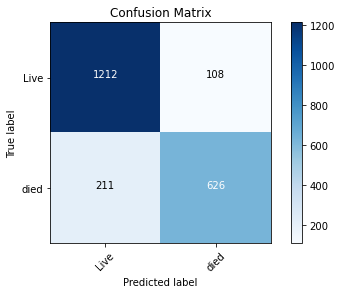

In [16]:
plot_confusion_matrix(cm=cf_matrix, classes=cm_plot_labels, title='Confusion Matrix')